# Import packages & functions

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from tqdm import tqdm
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

import ddp_config
distributed,local_rank = ddp_config.ddp_test()
if device=='cuda': torch.cuda.set_device(local_rank)

import utils
from models import Clipper, BrainNetwork, BrainDiffusionPrior, Voxel2StableDiffusionModel

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices

seed=42
utils.seed_everything(seed=seed)

# Load CLIP extractor
clip_extractor = Clipper("ViT-L/14", device=device)

/fsx/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda
NOT using distributed parallel processing!
ViT-L/14 cuda


# CLIP retrieval evaluation

### Load model checkpoint

In [2]:
# model_name = "prior-w-voxel2clip"

# outdir = f'../train_logs/models/{model_name}/test'

# ckpt_path = os.path.join(outdir, f'ckpt-best.pth')

ckpt_path = '/fsx/jimgoo/git/fMRI-reconstruction-NSD/train_logs/models/prior-w-voxel2clip/test/ckpt-best.pth'

print("ckpt_path",ckpt_path)

ckpt_path /fsx/jimgoo/git/fMRI-reconstruction-NSD/train_logs/models/prior-w-voxel2clip/test/ckpt-best.pth


### Load pretrained weights onto model

In [3]:
voxel2clip = BrainNetwork(out_dim=768)

# need folder "checkpoints" with following files
# wget https://huggingface.co/nousr/conditioned-prior/raw/main/vit-l-14/aesthetic/prior_config.json
# wget https://huggingface.co/nousr/conditioned-prior/resolve/main/vit-l-14/aesthetic/best.pth

def load_prior(ckpt_path, plot=False):
    if plot:
        utils.plot_prior_ckpt(ckpt_path)
    
    diffusion_prior = BrainDiffusionPrior.from_pretrained(
        # kwargs for DiffusionPriorNetwork
        dict(),
        # kwargs for DiffusionNetwork
        dict(
            condition_on_text_encodings=False,
            timesteps=1000,
            voxel2clip=voxel2clip,
        ),
        ckpt_dir='./checkpoints/',
    )

    ckpt = torch.load(ckpt_path, map_location=device)
    state_dict = ckpt['model_state_dict']
    
    # fix DDP keys
    for key in list(state_dict.keys()):
        if 'module.' in key:
            state_dict[key.replace('module.', '')] = state_dict[key]
            del state_dict[key]
    
    diffusion_prior.load_state_dict(state_dict)
    diffusion_prior.eval().to(device);
    return diffusion_prior

diffusion_prior = load_prior(ckpt_path)

print("loaded")

loaded


### Prep data loader

In [4]:
batch_size = 300 # same as used in mind_reader

image_var = 'images'

train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"
val_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
meta_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/metadata_subj01.json"

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

try:
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=train_url,
        val_url=val_url,
        meta_url=meta_url,
        num_samples=None,
        # seed=seed,
        voxels_key=voxels_key,
    )
except: # assuming error because urls were not valid
    print("Pulling data directly from huggingface...\n")
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=None,
        val_url=None,
        meta_url=None,
        num_samples=None,
        # seed=seed,
        voxels_key=voxels_key,
    )

# check that your data loader is working
for val_i, (voxel, img_input, key) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("key[:2]",key[:2])
    break

Getting dataloaders...
Pulling data directly from huggingface...

Getting dataloaders...
train_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/train/train_subj01_{0..49}.tar
val_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/val/val_subj01_0.tar
num_devices 1
num_workers 1
batch_size 300
val_batch_size 300
global_batch_size 300
num_worker_batches 83
num_train 24983
num_val 492
cache_dir /tmp/wds-cache
validation: num_worker_batches 2
idx 0
voxel.shape torch.Size([300, 15724])
img_input.shape torch.Size([300, 3, 256, 256])
key[:2] ['sample00002', 'sample00013']


## Forward / Backward quantification

In [6]:
percent_correct_fwd, percent_correct_bwd = None, None

for val_i, (voxel, img, trial) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = voxel.to(device)
            
            emb = clip_extractor.embed_image(img) # CLIP-Image
            
            #emb = clip_extractor.embed_curated_annotations(subj01_annots[trial]) # CLIP-Text
            
            # l2norm + scaling 
            emb_ = nn.functional.normalize(diffusion_prior.voxel2clip(voxel),dim=-1) * diffusion_prior.image_embed_scale

            labels = torch.arange(len(emb)).to(device)
            bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
            fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

            if percent_correct_fwd is None:
                cnt=1
                percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
                percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
            else:
                cnt+=1
                percent_correct_fwd += utils.topk(fwd_sim, labels,k=1)
                percent_correct_bwd += utils.topk(bwd_sim, labels,k=1)
percent_correct_fwd /= cnt
percent_correct_bwd /= cnt
print("fwd percent_correct", percent_correct_fwd)
print("bwd percent_correct", percent_correct_bwd)

fwd percent_correct tensor(0.5400, device='cuda:0')
bwd percent_correct tensor(0.5083, device='cuda:0')


### Plot some of the results

Forward retrieval


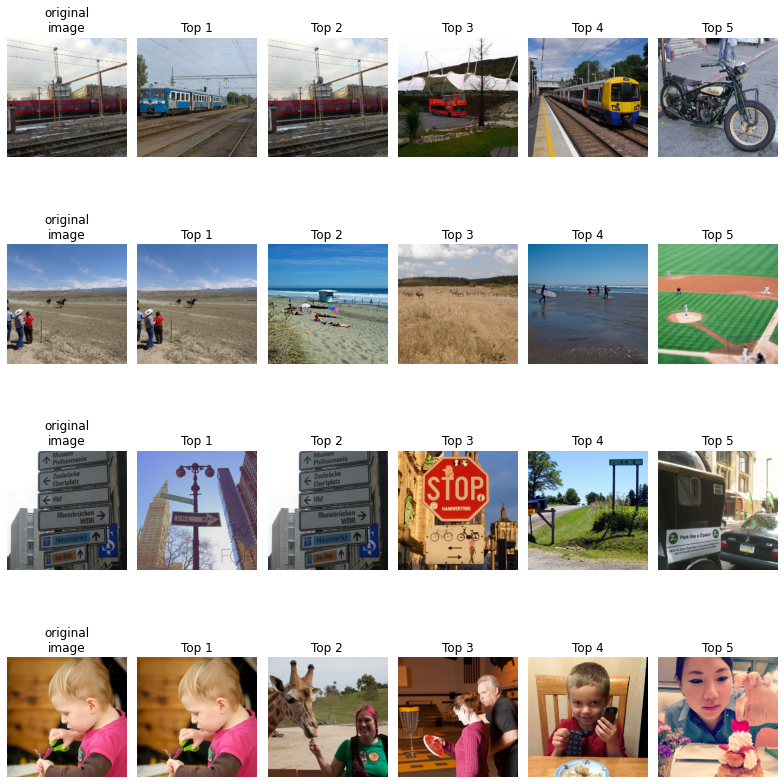

In [7]:
print("Forward retrieval")
try:
    fwd_sim = np.array(fwd_sim.cpu())
except:
    fwd_sim = np.array(fwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

Backward retrieval


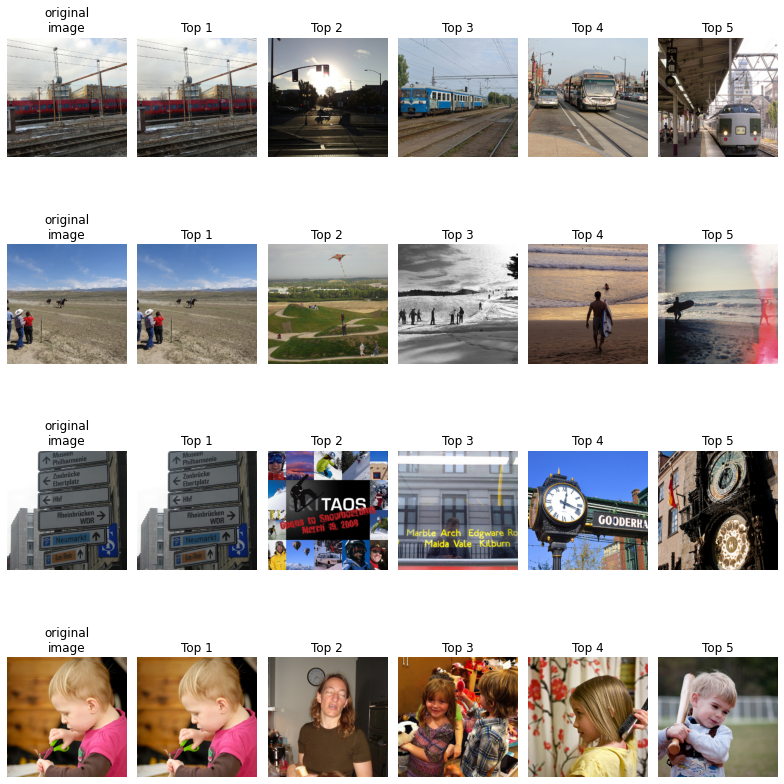

In [8]:
print("Backward retrieval")
try:
    bwd_sim = np.array(bwd_sim.cpu())
except:
    bwd_sim = np.array(bwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(bwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

# Reconstruction evaluation

### Load model checkpoint

In [9]:
# ckpt_path = 'checkpoints/image-ckpt-best.pth'
# print("ckpt_path",ckpt_path)
# checkpoint = torch.load(ckpt_path, map_location=device)

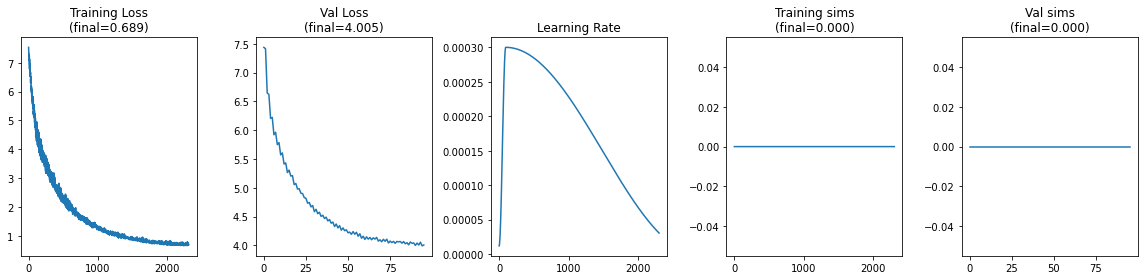

In [10]:
# image
diffusion_prior_img = load_prior(
    '/fsx/jimgoo/git/fMRI-reconstruction-NSD/train_logs/models/prior-w-voxel2clip/1D_combo-image/ckpt-best.pth',
    plot=True,
)

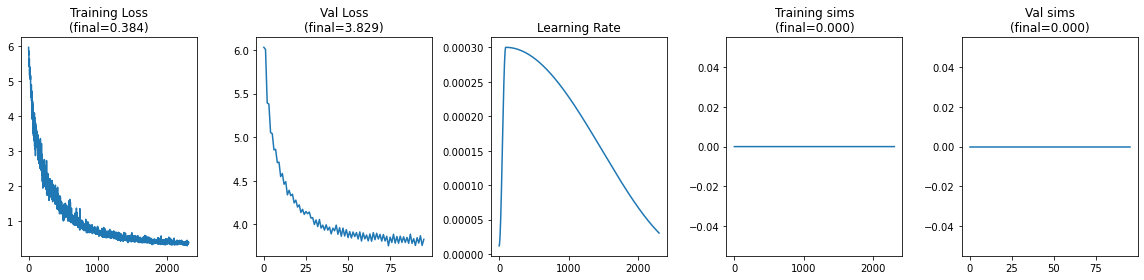

In [11]:
# text
diffusion_prior_txt = load_prior(
    '/fsx/jimgoo/git/fMRI-reconstruction-NSD/train_logs/models/prior-w-voxel2clip/1D_combo-text/ckpt-best.pth',
    plot=True,
)

### Load pretrained weights onto model

### Prep data loader

In [12]:
batch_size = 3 # assuming we are averaging 3 trials repetitions into 1

image_var = 'images'

# train_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset/train/train_subj01_{0..17}.tar"
# val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset/val/val_subj01_0.tar"
# meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset/metadata_subj01.json"

# train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..17}.tar"
# val_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
# meta_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/metadata_subj01.json"

train_url, val_url = utils.get_huggingface_urls()
meta_url = None

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

try:
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=train_url,
        val_url=val_url,
        meta_url=meta_url,
        voxels_key=voxels_key,
    )
except: # assuming error because urls were not valid
    print("Pulling data directly from huggingface...\n")
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=None,
        val_url=None,
        meta_url=None,
        voxels_key=voxels_key,
    )

# check that your data loader is working
for val_i, (voxel, img_input, key) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("key[:2]",key[:2])
    break

Getting dataloaders...
train_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/train/train_subj01_{0..49}.tar
val_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/val/val_subj01_0.tar
num_devices 1
num_workers 1
batch_size 3
val_batch_size 3
global_batch_size 3
num_worker_batches 8327
num_train 24983
num_val 492
cache_dir /tmp/wds-cache
validation: num_worker_batches 164
idx 0
voxel.shape torch.Size([3, 15724])
img_input.shape torch.Size([3, 3, 256, 256])
key[:2] ['sample00002', 'sample00013']


### Load SD variations model

In [13]:
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel, UniPCMultistepScheduler

torch_dtype = torch.float16 ## use this so we have enough memory for two diffusion priors

sd_cache_dir = '/fsx/home-paulscotti/.cache/huggingface/diffusers/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc'
# sd_cache_dir = '/scratch/gpfs/KNORMAN/nsd/stable_recons/models/sd-image-variations-diffusers/snapshots/fffa9500babf6ab7dfdde36a35ccef6d814ae432'
if not os.path.isdir(sd_cache_dir): # download from huggingface if not already downloaded / cached
    from diffusers import StableDiffusionImageVariationPipeline
    print("Downloading lambdalabs/sd-image-variations-diffusers from huggingface...")
    sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained(
        "lambdalabs/sd-image-variations-diffusers", 
        revision="v2.0",
        torch_dtype=torch_dtype,
    )
    sd_cache_dir = "lambdalabs/sd-image-variations-diffusers"

unet = UNet2DConditionModel.from_pretrained(sd_cache_dir,subfolder="unet", torch_dtype=torch_dtype).to(device)
unet.eval() # dont want to train model
unet.requires_grad_(False) # dont need to calculate gradients

vae = AutoencoderKL.from_pretrained(sd_cache_dir,subfolder="vae", torch_dtype=torch_dtype).to(device)
vae.eval()
vae.requires_grad_(False)

noise_scheduler = PNDMScheduler.from_pretrained(sd_cache_dir, subfolder="scheduler")
noise_scheduler = UniPCMultistepScheduler.from_config(noise_scheduler.config)

pass

Fetching 11 files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 829.84it/s]


## Check autoencoder works

In [14]:
# voxel2sd = Voxel2StableDiffusionModel()
# state_dict = torch.load('checkpoints/ckpt-epoch099.pth', map_location='cpu')["model_state_dict"]
# for key in list(state_dict.keys()):
#     if 'module.' in key:
#         state_dict[key.replace('module.', '')] = state_dict[key]
#         del state_dict[key]
# voxel2sd.load_state_dict(state_dict)
# voxel2sd.eval()
# pass

In [15]:
# voxels, images, _ = next(iter(val_dl))
# voxels = voxels[:3]
# images = images[:3]

# with torch.no_grad():
#     preds = voxel2sd(voxels.float())
#     reconst = vae.decode(preds.to(device)/0.18215).sample

# for b in range(len(voxels)):
#     plt.imshow(utils.torch_to_Image(((reconst[b]/2 + 0.5)*255).byte()))
#     plt.show()
#     plt.imshow(utils.torch_to_Image((images[b]*255).byte()))
#     plt.show()

## Reconstruction via diffusion, one at a time
This will take awhile!!

**Is there a way to prevent query_laion from failing every so often?**

**Will need to implement better checking of whether the nearest neighbor is the exact same image as the target. If so, choose next neighbor. Current implementation compares the CLIP embeddings and if it's a certain threshold of similarity it goes to next neighbor. But in my testing it seems to miss some neighbors and incorrectly classify other neighbors as the original target when it's not. Perhaps use perceptual image hashing instead of CLIP comparison? (see image_finder.py)**

In [16]:
# !rm -rf evals

In [ ]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

#diffusion_priors = [diffusion_prior_img]
#diffusion_priors = [diffusion_prior_txt]
diffusion_priors = [diffusion_prior_img, diffusion_prior_txt]
!mkdir -p evals

all_images = None
all_clip_recons = None
all_brain_recons = None
all_laion_picks = None

recons_per_clip = 1
recons_per_brain = 8

retrieve = True

batch_size = 1
assert batch_size == 1

for val_i, (voxel, img, trial) in enumerate(tqdm(val_dl,total=num_val//3)):
    voxel = torch.mean(voxel,axis=0).unsqueeze(0)
    img = img[[0]]
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            # ae_preds = voxel2sd(voxels.float())
            # blurry_recons = vae.decode(ae_preds.to(device)/0.18215).sample

            grid, clip_recons, brain_recons, laion_best_picks = utils.reconstruct_from_clip(
                img, voxel,
                diffusion_priors, 
                clip_extractor, unet, vae, noise_scheduler,
                img_lowlevel = None,
                num_inference_steps = 20,
                n_samples_save = batch_size,
                recons_per_clip = recons_per_clip,
                recons_per_brain = recons_per_brain,
                guidance_scale = 7.5,
                img2img_strength = .9, # 0=fully rely on img_lowlevel, 1=not doing img2img
                timesteps = 1000,
                seed = seed,
                distributed = distributed,
                retrieve = retrieve,
            )
            grid.savefig(f'evals/val_{val_i}.png')
            plt.close()
            if all_brain_recons is None:
                all_brain_recons = brain_recons
                all_clip_recons = clip_recons
                all_images = img
                all_laion_picks = laion_best_picks
            else:
                all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
                all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
                all_images = torch.vstack((all_images,img))
                all_laion_picks = np.hstack((all_laion_picks,laion_best_picks))

all_brain_recons = all_brain_recons.view(-1,recons_per_brain,3,512,512)
all_clip_recons = all_clip_recons.view(-1,recons_per_clip,3,512,512)
all_laion_picks = torch.Tensor(all_laion_picks)
#  brain_recons = brain_recons[:,laion_best_picks]

print("all_brain_recons.shape",all_brain_recons.shape)
print("all_clip_recons.shape",all_clip_recons.shape)
print("all_images.shape",all_images.shape)
print("all_laion_picks.shape",all_laion_picks.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2023-03-17 21:19:01


  9%|███████████████▋                                                                                                                                                            | 15/164 [26:35<5:54:19, 142.68s/it]/fsx/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 11%|██████████████████▉                                                                                                                                                          | 18/164 [30:08<3:54:22, 96.32s/it]

query_laion failed! probably due to 'TooManyRedirects: Exceeded 30 redirects.' error.


 15%|█████████████████████████▏                                                                                                                                                  | 24/164 [45:42<4:52:10, 125.22s/it]

query_laion failed! probably due to 'TooManyRedirects: Exceeded 30 redirects.' error.


 15%|██████████████████████████                                                                                                                                                 | 25/164 [55:35<10:15:14, 265.57s/it]

In [2]:
all_laion_picks.shape

In [1]:
ls evals

In [ ]:
torch.save(all_brain_recons,'evals/all_brain_recons')
torch.save(all_clip_recons,'evals/all_clip_recons')
torch.save(all_images,'evals/all_images')
torch.save(all_laion_picks,'evals/all_laion_picks')

In [6]:
# load variables if above cell was previously completed
all_brain_recons = torch.load('evals/all_brain_recons')
all_clip_recons = torch.load('evals/all_clip_recons')
all_images = torch.load('evals/all_images')
all_laion_picks = torch.load('evals/all_laion_picks')

## FID evaluation

In [7]:
# pick the best reconstructions via all_laion_picks, then compare best reconstructions with the original actual images
fake_images = torch.Tensor([])
for i in range(len(all_brain_recons)):
    fake_images = torch.cat((fake_images, all_brain_recons[i,int(all_laion_picks[i])][None]))

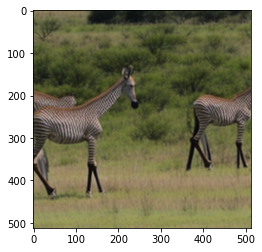

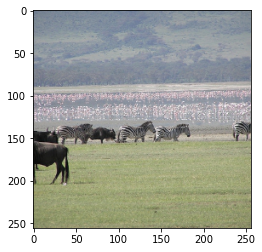

In [10]:
plt.imshow(utils.torch_to_Image(fake_images[0]))
plt.show()

plt.imshow(utils.torch_to_Image(all_images[0]))
plt.show()

In [24]:
import  pytorch_fid_wrapper as pfw

# the last feature layer (2048-dim) before FCs was the one used in mind_reader, but you need >=2048 images to calculate this (which we don't have)
dims = 64 # 2048

assert len(fake_images) >= dims

pfw.set_config(batch_size=4, dims=dims, device=device)

# automatically resizes to 299x299 suitable for Inception V3
val_fid = pfw.fid(fake_images.float(), real_images=all_images.float())
print(val_fid)

10.124700296065491


## 2-way identification

In [28]:
def l2norm(x):
    return nn.functional.normalize(x, dim=-1)

def two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=1):
    all_per_correct = []
    all_l2dist_list = []
    for loops in tqdm(range(num_loops)):
        per_correct = []
        l2dist_list = []
        for irecon, recon in enumerate(all_brain_recons):
            with torch.no_grad():        
                real = model(preprocess(all_images[irecon]).unsqueeze(0)).float()
                fake = model(preprocess(recon[0]).unsqueeze(0)).float()
                rand_idx = np.random.randint(len(all_brain_recons))
                while irecon == rand_idx:
                    rand_idx = np.random.randint(len(all_brain_recons))
                rand = model(preprocess(all_brain_recons[rand_idx,0]).unsqueeze(0)).float()

                l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
                l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

                if l2dist_fake < l2dist_rand:
                    per_correct.append(1)
                else:
                    per_correct.append(0)
                l2dist_list.append(l2dist_fake)
        all_per_correct.append(np.mean(per_correct))
        all_l2dist_list.append(np.mean(l2dist_list))
    return all_per_correct, all_l2dist_list

def two_way_identification_clip(all_brain_recons, all_images, num_loops=1):
    all_per_correct = []
    all_l2dist_list = []
    for loops in tqdm(range(num_loops)):
        per_correct = []
        l2dist_list = []
        for irecon, recon in enumerate(all_brain_recons):
            with torch.no_grad():       
                real = clip_extractor.embed_image(all_images[irecon].unsqueeze(0)).float()
                fake = clip_extractor.embed_image(recon[0].unsqueeze(0)).float()
                rand_idx = np.random.randint(len(all_brain_recons))
                while irecon == rand_idx:
                    rand_idx = np.random.randint(len(all_brain_recons))
                rand = clip_extractor.embed_image(all_brain_recons[rand_idx,0].unsqueeze(0)).float()

                l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
                l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

                if l2dist_fake < l2dist_rand:
                    per_correct.append(1)
                else:
                    per_correct.append(0)
                l2dist_list.append(l2dist_fake.item())
        all_per_correct.append(np.mean(per_correct))
        all_l2dist_list.append(np.mean(l2dist_list))
    return all_per_correct, all_l2dist_list

### AlexNet

In [30]:
from torchvision.models import alexnet, AlexNet_Weights

weights = AlexNet_Weights.DEFAULT
model = alexnet(weights=weights).eval()
preprocess = weights.transforms()

layer = 'late' # corresponds to layers used in Takagi & Nishimoto
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
model.avgpool=nn.Identity()
model.classifier=nn.Identity()
print(model)

all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10)
        
print(f"\n---{layer}---")
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")
        
layer = 'mid'
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
print(f"\n---{layer}---")
all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

layer = 'early'
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
print(f"\n---{layer}---")
all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Identity()
    (9): Identity()
    (10): Identity()
    (11): Identity()
    (12): Identity()
  )
  (avgpool): Identity()
  (classifier): Identity()
)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]



---late---
2-way Percent Correct (mu, std): 0.74 | 0.05
Avg l2dist_fake (mu, std): 0.0019 | 0.0000

---mid---


100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.13s/it]


2-way Percent Correct (mu, std): 0.62 | 0.04
Avg l2dist_fake (mu, std): 0.0014 | 0.0000

---early---


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]

2-way Percent Correct (mu, std): 0.63 | 0.04
Avg l2dist_fake (mu, std): 0.0013 | 0.0000


### InceptionV3

In [31]:
from torchvision.models import inception_v3, Inception_V3_Weights

weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights).eval()
preprocess = weights.transforms()

model.dropout = nn.Identity()
model.fc = nn.Identity()
print(model)

all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=30)
        
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

100%|███████████████████████████████████████████| 30/30 [10:27<00:00, 20.91s/it]

2-way Percent Correct (mu, std): 0.92 | 0.03
Avg l2dist_fake (mu, std): 0.0130 | 0.0000


### CLIP

In [32]:
all_per_correct, all_l2dist_list = two_way_identification_clip(all_brain_recons, all_images, num_loops=10)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

100%|███████████████████████████████████████████| 10/10 [00:44<00:00,  4.43s/it]

2-way Percent Correct (mu, std): 0.97 | 0.01
Avg l2dist_fake (mu, std): 0.0214 | 0.0000


## SSIM

In [ ]:
## insert ssim code here
# see https://github.com/zijin-gu/meshconv-decoding/issues/3

## PixCorr

In [12]:
## insert pixcorr code here

# Import packages & functions

In [1]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from tqdm import tqdm
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:",device)

import ddp_config
distributed,local_rank = ddp_config.ddp_test()
if device=='cuda': torch.cuda.set_device(local_rank)

import utils
from models import Clipper, BrainNetwork, BrainDiffusionPrior, Voxel2StableDiffusionModel

num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1
num_workers = num_devices

seed=42
utils.seed_everything(seed=seed)

# Load CLIP extractor
clip_extractor = Clipper("ViT-L/14", device=device)

/fsx/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda
NOT using distributed parallel processing!
ViT-L/14 cuda


# CLIP retrieval evaluation

### Load model checkpoint

In [4]:
# model_name = "prior-w-voxel2clip"

# outdir = f'../train_logs/models/{model_name}/test'

# ckpt_path = os.path.join(outdir, f'ckpt-best.pth')

ckpt_path = '/fsx/jimgoo/git/fMRI-reconstruction-NSD/train_logs/models/prior-w-voxel2clip/test'

print("ckpt_path",ckpt_path)

ckpt_path ../train_logs/models/prior-w-voxel2clip/test/ckpt-best.pth


### Load pretrained weights onto model

In [5]:
voxel2clip = BrainNetwork(out_dim=768)

# need folder "checkpoints" with following files
# wget https://huggingface.co/nousr/conditioned-prior/raw/main/vit-l-14/aesthetic/prior_config.json
# wget https://huggingface.co/nousr/conditioned-prior/resolve/main/vit-l-14/aesthetic/best.pth

def load_prior(ckpt_path, plot=False):
    if plot:
        utils.plot_prior_ckpt(ckpt_path)
    
    diffusion_prior = BrainDiffusionPrior.from_pretrained(
        # kwargs for DiffusionPriorNetwork
        dict(),
        # kwargs for DiffusionNetwork
        dict(
            condition_on_text_encodings=False,
            timesteps=1000,
            voxel2clip=voxel2clip,
        ),
        ckpt_dir='./checkpoints/',
    )

    ckpt = torch.load(ckpt_path, map_location=device)
    state_dict = ckpt['model_state_dict']
    
    # fix DDP keys
    for key in list(state_dict.keys()):
        if 'module.' in key:
            state_dict[key.replace('module.', '')] = state_dict[key]
            del state_dict[key]
    
    diffusion_prior.load_state_dict(state_dict)
    diffusion_prior.eval().to(device);
    return diffusion_prior

diffusion_prior = load_prior(ckpt_path)

print("loaded")

loaded


### Prep data loader

In [6]:
batch_size = 300 # same as used in mind_reader

image_var = 'images'

train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..49}.tar"
val_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
meta_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/metadata_subj01.json"

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

try:
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=train_url,
        val_url=val_url,
        meta_url=meta_url,
        num_samples=None,
        # seed=seed,
        voxels_key=voxels_key,
    )
except: # assuming error because urls were not valid
    print("Pulling data directly from huggingface...\n")
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=None,
        val_url=None,
        meta_url=None,
        num_samples=None,
        # seed=seed,
        voxels_key=voxels_key,
    )

# check that your data loader is working
for val_i, (voxel, img_input, key) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("key[:2]",key[:2])
    break

Getting dataloaders...
Pulling data directly from huggingface...

Getting dataloaders...
train_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/train/train_subj01_{0..49}.tar
val_url https://huggingface.co/datasets/pscotti/naturalscenesdataset/resolve/9947586218b6b7c8cab804009ddca5045249a38d/webdataset/val/val_subj01_0.tar
num_devices 1
num_workers 1
batch_size 300
val_batch_size 300
global_batch_size 300
num_worker_batches 83
num_train 24983
num_val 492
cache_dir /tmp/wds-cache
validation: num_worker_batches 2
idx 0
voxel.shape torch.Size([300, 15724])
img_input.shape torch.Size([300, 3, 256, 256])
key[:2] ['sample00002', 'sample00013']


## Forward / Backward quantification

In [5]:
percent_correct_fwd, percent_correct_bwd = None, None

for val_i, (voxel, img, trial) in enumerate(val_dl):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            voxel = voxel.to(device)
            
            emb = clip_extractor.embed_image(img) # CLIP-Image
            
            #emb = clip_extractor.embed_curated_annotations(subj01_annots[trial]) # CLIP-Text
            
            # l2norm + scaling 
            emb_ = nn.functional.normalize(diffusion_prior.voxel2clip(voxel),dim=-1) * diffusion_prior.image_embed_scale

            labels = torch.arange(len(emb)).to(device)
            bwd_sim = utils.batchwise_cosine_similarity(emb,emb_)  # clip, brain
            fwd_sim = utils.batchwise_cosine_similarity(emb_,emb)  # brain, clip

            if percent_correct_fwd is None:
                cnt=1
                percent_correct_fwd = utils.topk(fwd_sim, labels,k=1)
                percent_correct_bwd = utils.topk(bwd_sim, labels,k=1)
            else:
                cnt+=1
                percent_correct_fwd += utils.topk(fwd_sim, labels,k=1)
                percent_correct_bwd += utils.topk(bwd_sim, labels,k=1)
percent_correct_fwd /= cnt
percent_correct_bwd /= cnt
print("fwd percent_correct", percent_correct_fwd)
print("bwd percent_correct", percent_correct_bwd)

fwd percent_correct tensor(0.5400, device='cuda:0')
bwd percent_correct tensor(0.5083, device='cuda:0')


### Plot some of the results

Forward retrieval


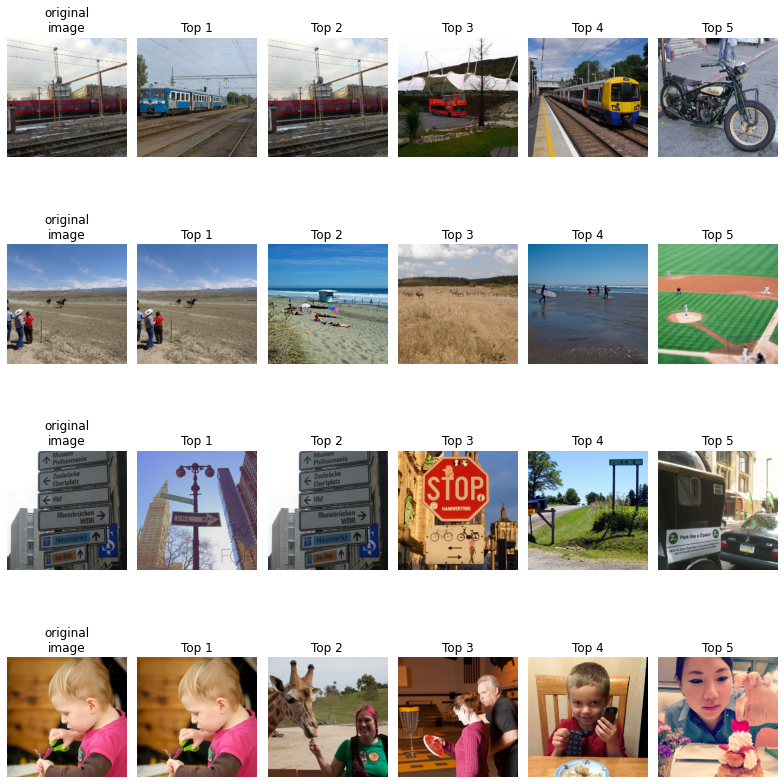

In [6]:
print("Forward retrieval")
try:
    fwd_sim = np.array(fwd_sim.cpu())
except:
    fwd_sim = np.array(fwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(fwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

Backward retrieval


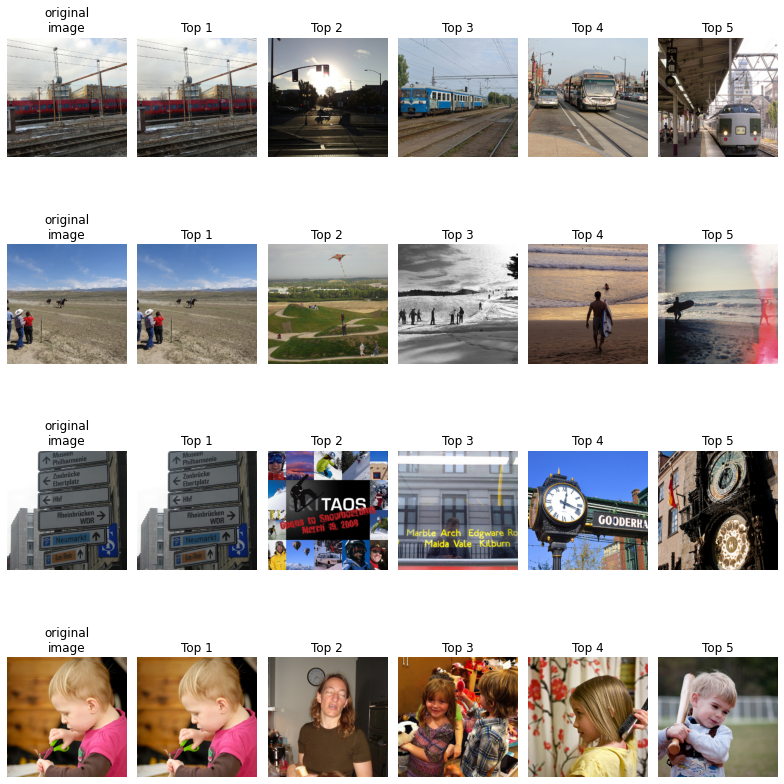

In [7]:
print("Backward retrieval")
try:
    bwd_sim = np.array(bwd_sim.cpu())
except:
    bwd_sim = np.array(bwd_sim)
fig, ax = plt.subplots(nrows=4, ncols=6, figsize=(11,12))
for trial in range(4):
    ax[trial, 0].imshow(utils.torch_to_Image(img[trial]))
    ax[trial, 0].set_title("original\nimage")
    ax[trial, 0].axis("off")
    for attempt in range(5):
        which = np.flip(np.argsort(bwd_sim[trial]))[attempt]
        ax[trial, attempt+1].imshow(utils.torch_to_Image(img[which]))
        ax[trial, attempt+1].set_title(f"Top {attempt+1}")
        ax[trial, attempt+1].axis("off")
fig.tight_layout()
plt.show()

# Reconstruction evaluation

### Load model checkpoint

In [8]:
# ckpt_path = 'checkpoints/image-ckpt-best.pth'
# print("ckpt_path",ckpt_path)
# checkpoint = torch.load(ckpt_path, map_location=device)

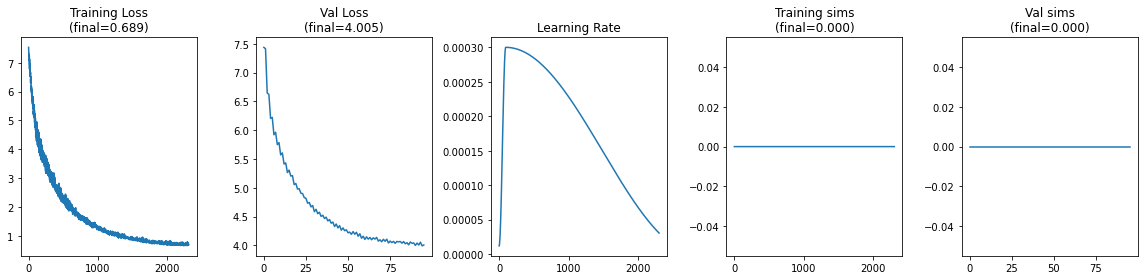

In [9]:
# image
diffusion_prior_img = load_prior(
    '/fsx/jimgoo/git/fMRI-reconstruction-NSD/train_logs/models/prior-w-voxel2clip/1D_combo-image/ckpt-best.pth',
    plot=True,
)

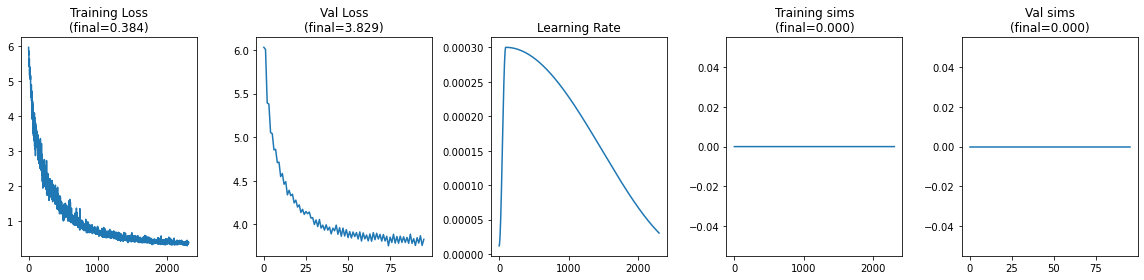

In [10]:
# text
diffusion_prior_txt = load_prior(
    '/fsx/jimgoo/git/fMRI-reconstruction-NSD/train_logs/models/prior-w-voxel2clip/1D_combo-text/ckpt-best.pth',
    plot=True,
)

### Load pretrained weights onto model

### Prep data loader

In [11]:
batch_size = 3 # assuming we are averaging 3 trials repetitions into 1

image_var = 'images'

train_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset/train/train_subj01_{0..17}.tar"
val_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset/val/val_subj01_0.tar"
meta_url = "/fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset/metadata_subj01.json"

# train_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/train/train_subj01_{0..17}.tar"
# val_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/val/val_subj01_0.tar"
# meta_url = "/scratch/gpfs/KNORMAN/webdataset_nsd/webdataset_split/metadata_subj01.json"

voxels_key = 'nsdgeneral.npy' # 1d inputs
# voxels_key = 'wholebrain_3d.npy' #3d inputs

try:
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=train_url,
        val_url=val_url,
        meta_url=meta_url,
        voxels_key=voxels_key,
    )
except: # assuming error because urls were not valid
    print("Pulling data directly from huggingface...\n")
    train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
        batch_size, image_var,
        num_devices=num_devices,
        num_workers=num_workers,
        train_url=None,
        val_url=None,
        meta_url=None,
        voxels_key=voxels_key,
    )

# check that your data loader is working
for val_i, (voxel, img_input, key) in enumerate(val_dl):
    print("idx",val_i)
    print("voxel.shape",voxel.shape)
    print("img_input.shape",img_input.shape)
    print("key[:2]",key[:2])
    break

Getting dataloaders...
train_url /fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset/train/train_subj01_{0..17}.tar
val_url /fsx/proj-medarc/fmri/natural-scenes-dataset/webdataset/val/val_subj01_0.tar
num_devices 1
num_workers 1
batch_size 3
val_batch_size 3
global_batch_size 3
num_worker_batches 9050
num_train 27150
num_val 300
cache_dir None
validation: num_worker_batches 100
idx 0
voxel.shape torch.Size([3, 15724])
img_input.shape torch.Size([3, 3, 256, 256])
key[:2] ['sample22000', 'sample12175']


### Load SD variations model

In [12]:
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel, UniPCMultistepScheduler

torch_dtype = torch.float16 ## use this so we have enough memory for two diffusion priors

sd_cache_dir = '/fsx/home-paulscotti/.cache/huggingface/diffusers/models--lambdalabs--sd-image-variations-diffusers/snapshots/a2a13984e57db80adcc9e3f85d568dcccb9b29fc'
# sd_cache_dir = '/scratch/gpfs/KNORMAN/nsd/stable_recons/models/sd-image-variations-diffusers/snapshots/fffa9500babf6ab7dfdde36a35ccef6d814ae432'
if not os.path.isdir(sd_cache_dir): # download from huggingface if not already downloaded / cached
    from diffusers import StableDiffusionImageVariationPipeline
    print("Downloading lambdalabs/sd-image-variations-diffusers from huggingface...")
    sd_pipe = StableDiffusionImageVariationPipeline.from_pretrained(
        "lambdalabs/sd-image-variations-diffusers", 
        revision="v2.0",
        torch_dtype=torch_dtype,
    )
    sd_cache_dir = "lambdalabs/sd-image-variations-diffusers"

unet = UNet2DConditionModel.from_pretrained(sd_cache_dir,subfolder="unet", torch_dtype=torch_dtype).to(device)
unet.eval() # dont want to train model
unet.requires_grad_(False) # dont need to calculate gradients

vae = AutoencoderKL.from_pretrained(sd_cache_dir,subfolder="vae", torch_dtype=torch_dtype).to(device)
vae.eval()
vae.requires_grad_(False)

noise_scheduler = PNDMScheduler.from_pretrained(sd_cache_dir, subfolder="scheduler")
noise_scheduler = UniPCMultistepScheduler.from_config(noise_scheduler.config)

pass

Fetching 11 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 8457.81it/s]


## Check autoencoder works

In [13]:
# voxel2sd = Voxel2StableDiffusionModel()
# state_dict = torch.load('checkpoints/ckpt-epoch099.pth', map_location='cpu')["model_state_dict"]
# for key in list(state_dict.keys()):
#     if 'module.' in key:
#         state_dict[key.replace('module.', '')] = state_dict[key]
#         del state_dict[key]
# voxel2sd.load_state_dict(state_dict)
# voxel2sd.eval()
# pass

In [14]:
# voxels, images, _ = next(iter(val_dl))
# voxels = voxels[:3]
# images = images[:3]

# with torch.no_grad():
#     preds = voxel2sd(voxels.float())
#     reconst = vae.decode(preds.to(device)/0.18215).sample

# for b in range(len(voxels)):
#     plt.imshow(utils.torch_to_Image(((reconst[b]/2 + 0.5)*255).byte()))
#     plt.show()
#     plt.imshow(utils.torch_to_Image((images[b]*255).byte()))
#     plt.show()

## Reconstruction via diffusion, one at a time
This will take awhile!!

**Is there a way to prevent query_laion from failing every so often?**

**Will need to implement better checking of whether the nearest neighbor is the exact same image as the target. If so, choose next neighbor. Current implementation compares the CLIP embeddings and if it's a certain threshold of similarity it goes to next neighbor. But in my testing it seems to miss some neighbors and incorrectly classify other neighbors as the original target when it's not. Perhaps use perceptual image hashing instead of CLIP comparison? (see image_finder.py)**

In [ ]:
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

#diffusion_priors = [diffusion_prior_img]
#diffusion_priors = [diffusion_prior_txt]
diffusion_priors = [diffusion_prior_img, diffusion_prior_txt]
!mkdir -p evals

all_images = None
all_clip_recons = None
all_brain_recons = None
all_laion_picks = None

recons_per_clip = 1
recons_per_brain = 8

retrieve = True

batch_size = 1
assert batch_size == 1

for val_i, (voxel, img, trial) in enumerate(tqdm(val_dl,total=num_val//3)):
    voxel = torch.mean(voxel,axis=0).unsqueeze(0)
    img = img[[0]]
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            # ae_preds = voxel2sd(voxels.float())
            # blurry_recons = vae.decode(ae_preds.to(device)/0.18215).sample

            grid, clip_recons, brain_recons, laion_best_picks = utils.reconstruct_from_clip(
                img, voxel,
                diffusion_priors, 
                clip_extractor, unet, vae, noise_scheduler,
                img_lowlevel = None,
                num_inference_steps = 20,
                n_samples_save = batch_size,
                recons_per_clip = recons_per_clip,
                recons_per_brain = recons_per_brain,
                guidance_scale = 7.5,
                img2img_strength = .9, # 0=fully rely on img_lowlevel, 1=not doing img2img
                timesteps = 1000,
                seed = seed,
                distributed = distributed,
                retrieve = retrieve,
            )
            grid.savefig(f'evals/val_{val_i}.png')
            plt.close()
            if all_brain_recons is None:
                all_brain_recons = brain_recons
                all_clip_recons = clip_recons
                all_images = img
                all_laion_picks = laion_best_picks
            else:
                all_brain_recons = torch.vstack((all_brain_recons,brain_recons))
                all_clip_recons = torch.vstack((all_clip_recons,clip_recons))
                all_images = torch.vstack((all_images,img))
                all_laion_picks = np.hstack((all_laion_picks,laion_best_picks))

all_brain_recons = all_brain_recons.view(-1,recons_per_brain,3,512,512)
all_clip_recons = all_clip_recons.view(-1,recons_per_clip,3,512,512)
all_laion_picks = torch.Tensor(all_laion_picks)
#  brain_recons = brain_recons[:,laion_best_picks]

print("all_brain_recons.shape",all_brain_recons.shape)
print("all_clip_recons.shape",all_clip_recons.shape)
print("all_images.shape",all_images.shape)
print("all_laion_picks.shape",all_laion_picks.shape)
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2023-03-17 18:21:48


 12%|████████████████████▋                                                                                                                                                       | 12/100 [24:07<3:02:34, 124.49s/it]/fsx/jimgoo/miniconda3/envs/medical-v1/lib/python3.10/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 32/100 [1:00:41<1:57:56, 104.07s/it]

In [2]:
all_laion_picks.shape

NameError: name 'all_laion_picks' is not defined

In [1]:
ls evals

val_0.png   val_14.png  val_2.png   val_25.png  val_30.png  val_8.png
val_1.png   val_15.png  val_20.png  val_26.png  val_31.png  val_9.png
val_10.png  val_16.png  val_21.png  val_27.png  val_4.png
val_11.png  val_17.png  val_22.png  val_28.png  val_5.png
val_12.png  val_18.png  val_23.png  val_29.png  val_6.png
val_13.png  val_19.png  val_24.png  val_3.png   val_7.png


In [ ]:
torch.save(all_brain_recons,'evals/all_brain_recons')
torch.save(all_clip_recons,'evals/all_clip_recons')
torch.save(all_images,'evals/all_images')
torch.save(all_laion_picks,'evals/all_laion_picks')

In [6]:
# load variables if above cell was previously completed
all_brain_recons = torch.load('evals/all_brain_recons')
all_clip_recons = torch.load('evals/all_clip_recons')
all_images = torch.load('evals/all_images')
all_laion_picks = torch.load('evals/all_laion_picks')

## FID evaluation

In [7]:
# pick the best reconstructions via all_laion_picks, then compare best reconstructions with the original actual images
fake_images = torch.Tensor([])
for i in range(len(all_brain_recons)):
    fake_images = torch.cat((fake_images, all_brain_recons[i,int(all_laion_picks[i])][None]))

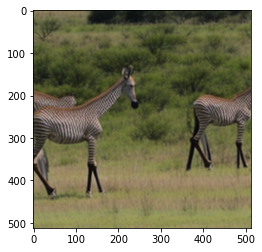

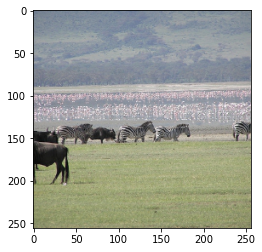

In [10]:
plt.imshow(utils.torch_to_Image(fake_images[0]))
plt.show()

plt.imshow(utils.torch_to_Image(all_images[0]))
plt.show()

In [24]:
import  pytorch_fid_wrapper as pfw

# the last feature layer (2048-dim) before FCs was the one used in mind_reader, but you need >=2048 images to calculate this (which we don't have)
dims = 64 # 2048

assert len(fake_images) >= dims

pfw.set_config(batch_size=4, dims=dims, device=device)

# automatically resizes to 299x299 suitable for Inception V3
val_fid = pfw.fid(fake_images.float(), real_images=all_images.float())
print(val_fid)

10.124700296065491


## 2-way identification

In [28]:
def l2norm(x):
    return nn.functional.normalize(x, dim=-1)

def two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=1):
    all_per_correct = []
    all_l2dist_list = []
    for loops in tqdm(range(num_loops)):
        per_correct = []
        l2dist_list = []
        for irecon, recon in enumerate(all_brain_recons):
            with torch.no_grad():        
                real = model(preprocess(all_images[irecon]).unsqueeze(0)).float()
                fake = model(preprocess(recon[0]).unsqueeze(0)).float()
                rand_idx = np.random.randint(len(all_brain_recons))
                while irecon == rand_idx:
                    rand_idx = np.random.randint(len(all_brain_recons))
                rand = model(preprocess(all_brain_recons[rand_idx,0]).unsqueeze(0)).float()

                l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
                l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

                if l2dist_fake < l2dist_rand:
                    per_correct.append(1)
                else:
                    per_correct.append(0)
                l2dist_list.append(l2dist_fake)
        all_per_correct.append(np.mean(per_correct))
        all_l2dist_list.append(np.mean(l2dist_list))
    return all_per_correct, all_l2dist_list

def two_way_identification_clip(all_brain_recons, all_images, num_loops=1):
    all_per_correct = []
    all_l2dist_list = []
    for loops in tqdm(range(num_loops)):
        per_correct = []
        l2dist_list = []
        for irecon, recon in enumerate(all_brain_recons):
            with torch.no_grad():       
                real = clip_extractor.embed_image(all_images[irecon].unsqueeze(0)).float()
                fake = clip_extractor.embed_image(recon[0].unsqueeze(0)).float()
                rand_idx = np.random.randint(len(all_brain_recons))
                while irecon == rand_idx:
                    rand_idx = np.random.randint(len(all_brain_recons))
                rand = clip_extractor.embed_image(all_brain_recons[rand_idx,0].unsqueeze(0)).float()

                l2dist_fake = torch.mean(torch.sqrt((l2norm(real) - l2norm(fake))**2))
                l2dist_rand = torch.mean(torch.sqrt((l2norm(real) - l2norm(rand))**2))

                if l2dist_fake < l2dist_rand:
                    per_correct.append(1)
                else:
                    per_correct.append(0)
                l2dist_list.append(l2dist_fake.item())
        all_per_correct.append(np.mean(per_correct))
        all_l2dist_list.append(np.mean(l2dist_list))
    return all_per_correct, all_l2dist_list

### AlexNet

In [30]:
from torchvision.models import alexnet, AlexNet_Weights

weights = AlexNet_Weights.DEFAULT
model = alexnet(weights=weights).eval()
preprocess = weights.transforms()

layer = 'late' # corresponds to layers used in Takagi & Nishimoto
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
model.avgpool=nn.Identity()
model.classifier=nn.Identity()
print(model)

all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10)
        
print(f"\n---{layer}---")
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")
        
layer = 'mid'
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
print(f"\n---{layer}---")
all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

layer = 'early'
for i,f in enumerate(model.features):
    if layer=='early' and i>1:
        model.features[i] = nn.Identity()
    elif layer=='mid' and i>4:
        model.features[i] = nn.Identity()
    elif layer=='late' and i>7:
        model.features[i] = nn.Identity()
print(f"\n---{layer}---")
all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=10)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Identity()
    (9): Identity()
    (10): Identity()
    (11): Identity()
    (12): Identity()
  )
  (avgpool): Identity()
  (classifier): Identity()
)


100%|███████████████████████████████████████████| 10/10 [00:16<00:00,  1.66s/it]



---late---
2-way Percent Correct (mu, std): 0.74 | 0.05
Avg l2dist_fake (mu, std): 0.0019 | 0.0000

---mid---


100%|███████████████████████████████████████████| 10/10 [00:11<00:00,  1.13s/it]


2-way Percent Correct (mu, std): 0.62 | 0.04
Avg l2dist_fake (mu, std): 0.0014 | 0.0000

---early---


100%|███████████████████████████████████████████| 10/10 [00:07<00:00,  1.27it/s]

2-way Percent Correct (mu, std): 0.63 | 0.04
Avg l2dist_fake (mu, std): 0.0013 | 0.0000


### InceptionV3

In [31]:
from torchvision.models import inception_v3, Inception_V3_Weights

weights = Inception_V3_Weights.DEFAULT
model = inception_v3(weights=weights).eval()
preprocess = weights.transforms()

model.dropout = nn.Identity()
model.fc = nn.Identity()
print(model)

all_per_correct, all_l2dist_list = two_way_identification(all_brain_recons, all_images, model, preprocess, num_loops=30)
        
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

100%|███████████████████████████████████████████| 30/30 [10:27<00:00, 20.91s/it]

2-way Percent Correct (mu, std): 0.92 | 0.03
Avg l2dist_fake (mu, std): 0.0130 | 0.0000


### CLIP

In [32]:
all_per_correct, all_l2dist_list = two_way_identification_clip(all_brain_recons, all_images, num_loops=10)
print(f"2-way Percent Correct (mu, std): {np.mean(all_per_correct):.2f} | {np.std(all_per_correct):.2f}")
print(f"Avg l2dist_fake (mu, std): {np.mean(all_l2dist_list):.4f} | {np.std(all_l2dist_list):.4f}")

100%|███████████████████████████████████████████| 10/10 [00:44<00:00,  4.43s/it]

2-way Percent Correct (mu, std): 0.97 | 0.01
Avg l2dist_fake (mu, std): 0.0214 | 0.0000


## SSIM

In [ ]:
## insert ssim code here
# see https://github.com/zijin-gu/meshconv-decoding/issues/3

## PixCorr

In [12]:
## insert pixcorr code here